In [1]:
# dataframe
import pandas as pd

# basic math and stats formulas and plots
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# train-test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# model metrics validation
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.metrics import Recall
from sklearn.metrics import recall_score

# neural network
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense

# Dataset transformation
First thing is importing the dataset and select only the columns that we will use for the neural network.

In [2]:
# Importing the dataset
df1 = pd.read_csv('trapani.csv')
columns = ['Julian', 'pressure', 'wind_direction', 'wind_speed', 'past_weather1', 'past_weather2', 'drybulb', 'dewpoint', 'fog']
df = df1[columns]

In [3]:
df.isna().sum()

Julian                0
pressure              0
wind_direction        0
wind_speed            0
past_weather1         0
past_weather2         0
drybulb           72782
dewpoint          72783
fog                   0
dtype: int64

Now we want to train the neural network with the data in which drybulb and dewpoint have been measured. So we drop all the rows with NaN values being that the only NaN are in these two columns. The next step is scaling all the numerical variables and transform the categorical variables in multiple binary variables.

In [4]:
df2 = df.copy()
df2 = df2.dropna()
df2 = df2.reset_index(drop = 1)

# Transforming the categorical variables
categorical = ['past_weather1', 'past_weather2']
df_cat = df2[categorical].copy()
df_cat = pd.get_dummies(df_cat, columns = df_cat.columns.values)

# Scaling the numerical variables
numerical = ['Julian', 'pressure', 'wind_direction', 'wind_speed', 'drybulb', 'dewpoint']
df_num = df2[numerical].copy()
scaler = StandardScaler()  
df_num1 = scaler.fit_transform(df_num)
df_num1 = pd.DataFrame(df_num1, columns = df_num.columns.values)

# Merging the categorical and numerical variables
dfNN = pd.concat([df_cat, df_num1], axis = 1)
dfNN['fog'] = df2['fog']
print(dfNN.shape)
dfNN.isna().sum()

(44330, 27)


past_weather1_0    0
past_weather1_1    0
past_weather1_2    0
past_weather1_3    0
past_weather1_4    0
past_weather1_5    0
past_weather1_6    0
past_weather1_7    0
past_weather1_8    0
past_weather1_9    0
past_weather2_0    0
past_weather2_1    0
past_weather2_2    0
past_weather2_3    0
past_weather2_4    0
past_weather2_5    0
past_weather2_6    0
past_weather2_7    0
past_weather2_8    0
past_weather2_9    0
Julian             0
pressure           0
wind_direction     0
wind_speed         0
drybulb            0
dewpoint           0
fog                0
dtype: int64

# Splitting

Now we can start to split the dataset in predictors and target and then in training and testing values (the test set size will be 20% of the dataset while the validation set size will be the 25%)

In [5]:
X = dfNN.drop('fog', axis=1)  
y = dfNN['fog']

# Split dataset into training set, test set and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

_, X_val, _, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

X_train, X_test, X_val, y_train, y_test, y_val = X_train.values, X_test.values, X_val.values, y_train.values, y_test.values, y_val.values

# Visualization of datasets shapes and fog percentages
fog_pct = np.sum(y) * 100 / len(y)

print(f'Training shape: {X_train.shape, y_train.shape}')
print(f'Validation shape: {X_val.shape, y_val.shape}')
print(f'Testing shape: {X_test.shape, y_test.shape}')
print(f'Fog percentage: {np.round(fog_pct, 3)}')


# condition to skip tuning

condition = 1

Training shape: ((35464, 26), (35464,))
Validation shape: ((11083, 26), (11083,))
Testing shape: ((8866, 26), (8866,))
Fog percentage: 0.074


# Fine Tuning
For the training of the neural network we start with a hyperparameter tuning. The grid is:  

- number of neurons: 16, 32, 64
- activation function (of the hidden layer): relu, sigmoid, tanh
- optimizer: SGD, Adam, RMSprop, Adadelta
- batch_size: 8, 16, 32

Being a binary classification the activation function of the last layer is set to sigmoid and the loss function is the binary crossentropy.   
The metrics considered apart from the loss are accuracy and recall. We added the recall because the dataset is extremely imbalanced so the accuracy is "falsely" high. So if we use the recall we know how many fog cases are predicted respect to the true number of fog cases.  
At this neural network we added a callback. Basically if the recall on the validation set doesn't increase for 10 epochs the neural network is forced to stop.  
For every set of parameters is stored the accuracy and the recall of the predictions on the test set.

In [6]:
# Fine tuning
activationL = ['relu', 'sigmoid', 'tanh']
results = []
counter = 0

# for neurons in [16, 32, 64]:
#     for activation in activationL:
#         for opt in ['SGD', 'Adam', 'RMSprop', 'Adadelta']:
#             for batch_size in [8, 16, 32]:

#                 np.random.seed(1)
#                 print('*' * 50)
#                 print('Parameters:')
#                 print(f'No. neurons: {neurons}')
#                 print(f'Activation: {activation}')
#                 print(f'Optimizer: {opt}')
#                 print(f'Batch size: {batch_size}')
                
#                 # Creation of the model
#                 model = Sequential()
#                 model.add(Dense(neurons, input_dim = X_train.shape[1], activation = activation))
#                 model.add(Dense(1, activation = 'sigmoid'))

#                 # Compile the model with custom recall metric
#                 model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Recall()])

#                 # Condition of early stopping by monitoring the recall on the validation set
#                 if counter == 0:
#                     es = EarlyStopping(monitor='val_recall', 
#                                     mode='max',
#                                     patience=25,
#                                     restore_best_weights=True)
#                 else:
#                     es = EarlyStopping(monitor=f'val_recall_{counter}', 
#                                     mode='max',
#                                     patience=25,
#                                     restore_best_weights=True)
                    
#                 counter += 1

#                 # LSTM fitting
#                 model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose = 1, epochs = 100, batch_size = batch_size, callbacks=[es])

#                 # Predictions of the model on the test set
#                 preds = np.round(model.predict(X_test), 0)
                
#                 # Storing the metrics (accuracy, recall) on the test set in a list
#                 score1 = recall_score(y_test, preds, pos_label=1)
#                 score2 = accuracy_score(y_test, preds)
#                 params = [neurons, activation, batch_size, opt, score1, score2]
#                 results.append(params)

# condition = 0

To select the parameters with best performances we take the parameters that bring to the best accuracy but also the parameters that bring to the best accuracy + recall

In [7]:
if condition==0:
    results_df=pd.DataFrame(results,columns=['neurons', 'activation', 'batch_size', 'opt', 'hops', 'score1', 'score2'])
    results_df.to_csv('MLP_trapaniTuning.csv',index=False)
else:
    results_df=pd.read_csv('MLP_trapaniTuning.csv')
    
    results = list(results_df.values)

# Best model selection

In [8]:
mix = [x[4] + x[5] for x in results]
best_mix_ind = mix.index(np.max(mix))
best_mix = results[best_mix_ind]


accuracies = [x[5] for x in results]
best_acc_ind = accuracies.index(np.max(accuracies))
best_acc = results[best_acc_ind]

# We'll take the best accuracy model

print(f'Best accuracy + recall: {best_mix}')
print(f'Best accuracy: {best_acc}')

Best accuracy + recall: [32 'relu' 8 'Adam' 0.7142857142857143 0.9996616286938868]
Best accuracy: [32 'relu' 8 'Adam' 0.7142857142857143 0.9996616286938868]


We run again the neural network with the best parameters to plot the results.

In [9]:
np.random.seed(1)

if condition == 1:
    metric = 'val_recall'
else:
    metric = f'val_recall_{counter}'

# Best parameters
neurons, activation, batch_size, opt = best_mix[0], best_mix[1], best_mix[2], best_mix[3]

model = Sequential()
model.add(Dense(neurons, input_dim = X_train.shape[1], activation = activation))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Recall()])

# Condition of early stopping by monitoring the recall on the validation set
es = EarlyStopping(monitor=metric, 
                mode='max',
                patience=25,
                restore_best_weights=True)

# Fitting the model and storing all metrics in the variable history
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), verbose = 1, epochs = 100, batch_size = batch_size, callbacks=[es])

Epoch 1/5
4433/4433 [==============================] - 8s 2ms/step - loss: 0.0164 - accuracy: 0.9971 - recall: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.9993 - val_recall: 0.0000e+00
Epoch 2/5
4433/4433 [==============================] - 7s 2ms/step - loss: 0.0027 - accuracy: 0.9992 - recall: 0.0769 - val_loss: 0.0018 - val_accuracy: 0.9993 - val_recall: 0.0000e+00
Epoch 3/5
4433/4433 [==============================] - 6s 1ms/step - loss: 0.0023 - accuracy: 0.9994 - recall: 0.2692 - val_loss: 0.0019 - val_accuracy: 0.9993 - val_recall: 0.3750
Epoch 4/5
4433/4433 [==============================] - 7s 2ms/step - loss: 0.0021 - accuracy: 0.9994 - recall: 0.3846 - val_loss: 0.0017 - val_accuracy: 0.9994 - val_recall: 0.2500
Epoch 5/5
4433/4433 [==============================] - 8s 2ms/step - loss: 0.0022 - accuracy: 0.9994 - recall: 0.3846 - val_loss: 0.0015 - val_accuracy: 0.9995 - val_recall: 0.2500


# Performances

In [10]:
def predictions_results(X, y, model):
    preds = np.round(model.predict(X),0)

    # Measure recall and accuracy of the prediction
    score1 = recall_score(y, preds, pos_label=1)
    score2 = accuracy_score(y, preds)
    # Plotting the metrics, classification report and the confusion matrix

    print(f'Accuracy: {round(score2 * 100, 2)}')
    print(f'Recall: {round(score1 * 100, 2)}')

    cm = confusion_matrix(y, preds)
    disp = ConfusionMatrixDisplay(cm)
    print(classification_report(y, preds))
    disp.plot()
    plt.show()

### Validation

347/347 [==============================] - 0s 1ms/step
Accuracy: 99.95
Recall: 25.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11075
           1       1.00      0.25      0.40         8

    accuracy                           1.00     11083
   macro avg       1.00      0.62      0.70     11083
weighted avg       1.00      1.00      1.00     11083



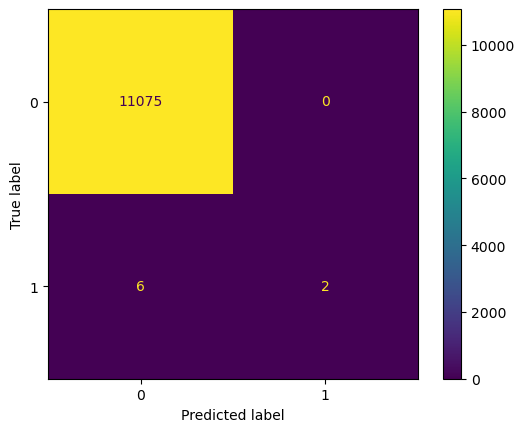

In [11]:
predictions_results(X_val, y_val, model)

### Test

278/278 [==============================] - 0s 1ms/step
Accuracy: 99.94
Recall: 42.86
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8859
           1       0.75      0.43      0.55         7

    accuracy                           1.00      8866
   macro avg       0.87      0.71      0.77      8866
weighted avg       1.00      1.00      1.00      8866



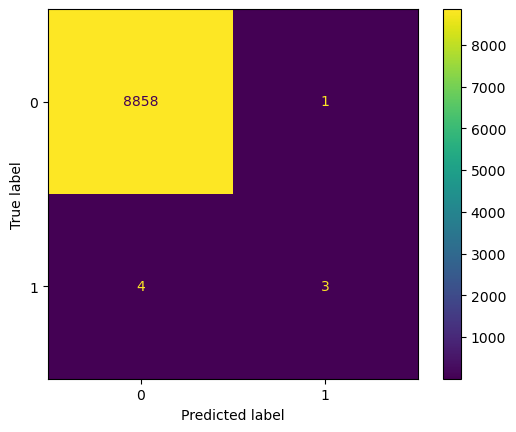

In [12]:
predictions_results(X_test, y_test, model)

### Metrics

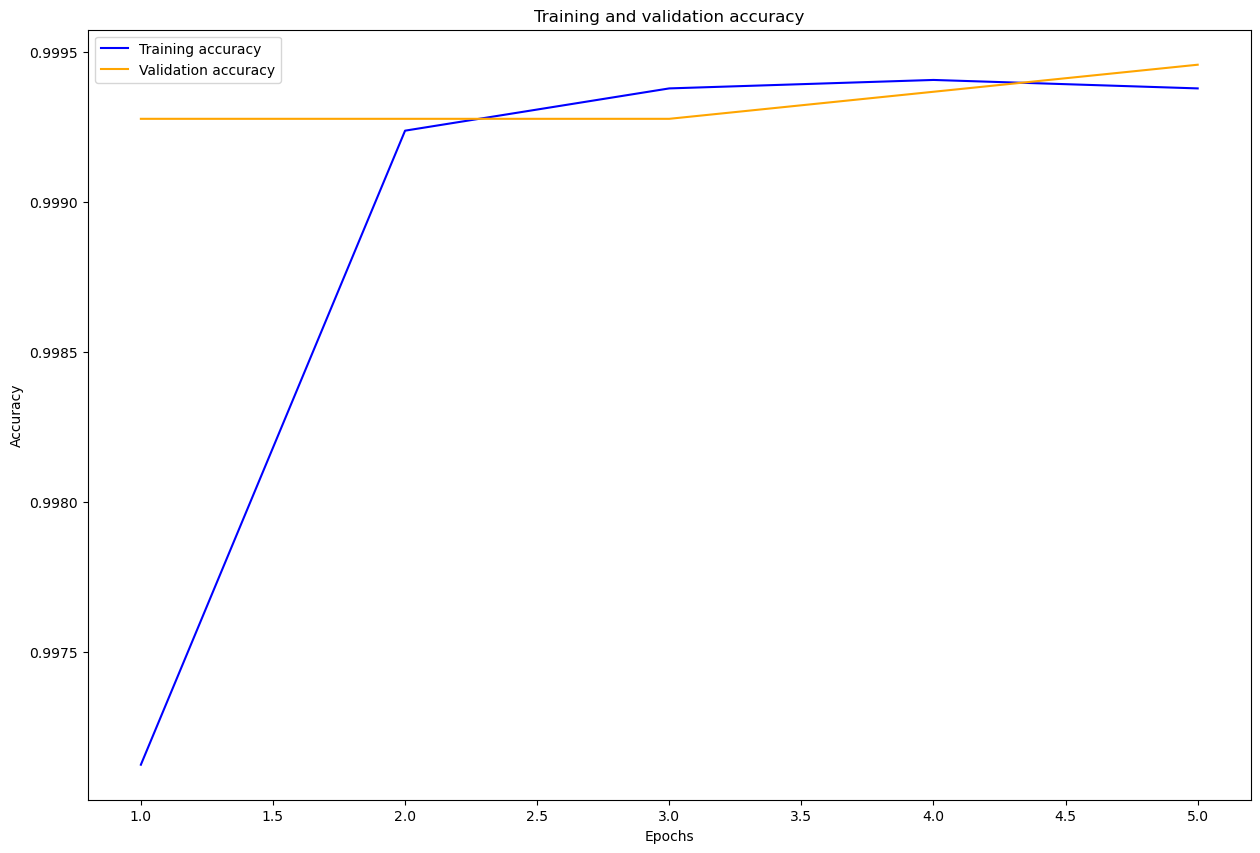

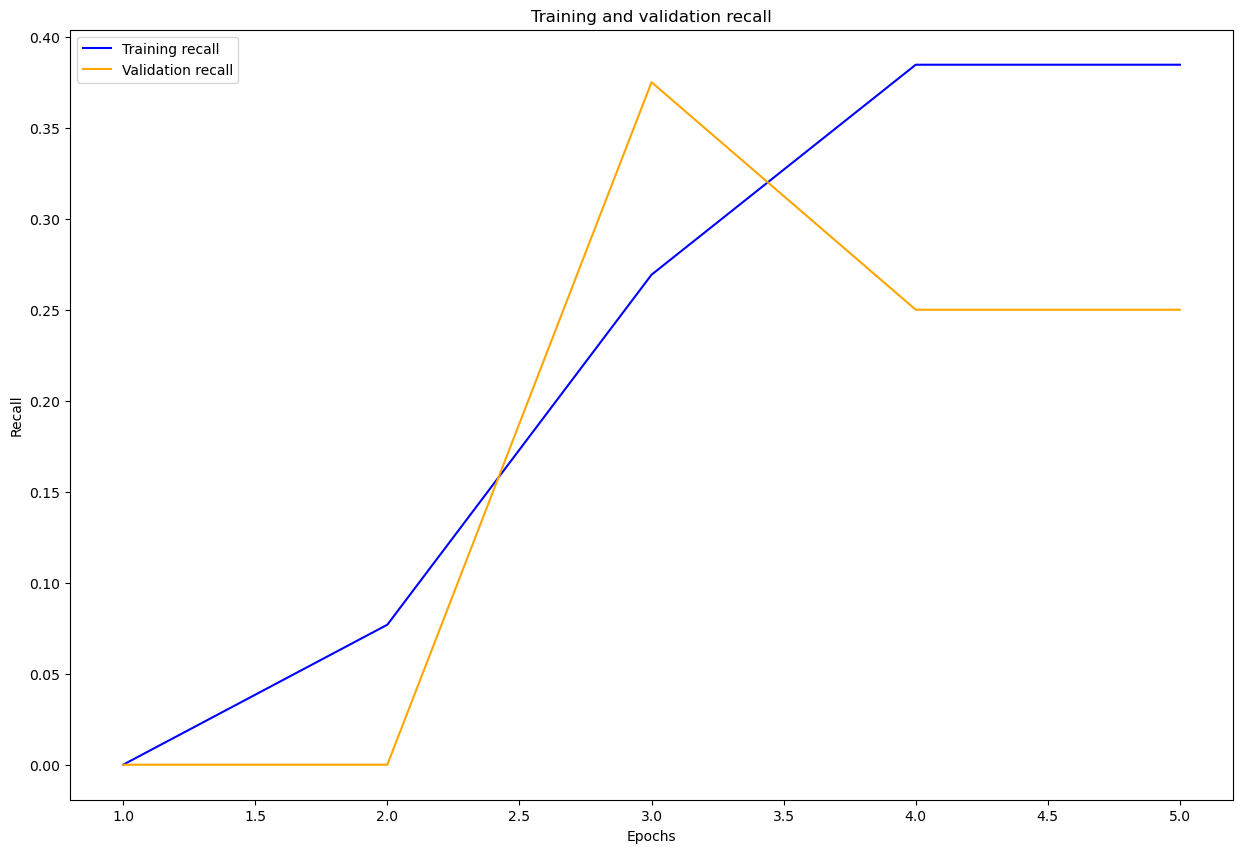

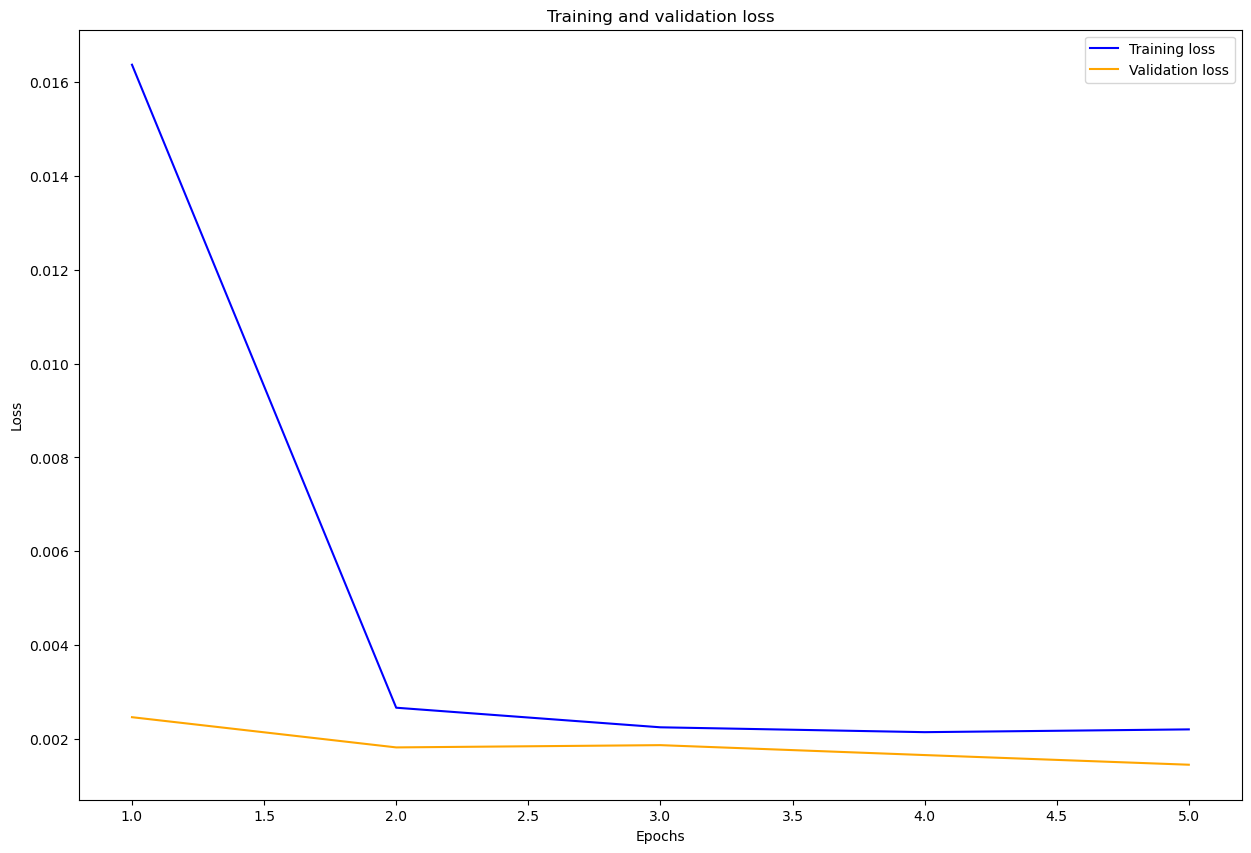

In [13]:
history_dict = history.history

# Loss
rec = history_dict[metric[4:]]
val_rec = history_dict[metric]

# Loss
loss = history_dict[f'loss']
val_loss = history_dict[f'val_loss']

# Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(val_loss) + 1) 

# Plotting accuracy
plt.figure(figsize = (15,10))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting recall
plt.figure(figsize = (15,10))
plt.plot(epochs, rec, 'b', label='Training recall')
plt.plot(epochs, val_rec, 'orange', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()


# Plotting loss
plt.figure(figsize = (15,10))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()